In [1]:
import json
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

asinToIndex = {}
index = 0
scoreMatrix = []
booksAsin = []
chunks = pd.read_json(
    '../Dataset/Books.json', lines=True, chunksize=500000, 
    typ="frame", orient="records", dtype={"asin": str, "overall": int}
)

nbChunks = 2
for chunk in chunks:
    for _, item in chunk.iterrows():
        asin = item["asin"]
        rate = item["overall"]

        if (asin not in asinToIndex):
            scoreMatrix.append([0,0,0,0,0])
            booksAsin.append(asin)
            asinToIndex[asin] = index
            index += 1

        row = asinToIndex[asin]
        scoreMatrix[row][rate-1] += 1
    nbChunks -= 1
    if (nbChunks == 0):
        break # comment to load everything

scoreMatrix = np.array(scoreMatrix)
pdScoreMat = pd.DataFrame(
    data=scoreMatrix,
    index=booksAsin,
    columns=[f"{i} ⭐" for i in range(1, 6)]
)
pdScoreMat

,1 ⭐,2 ⭐,3 ⭐,4 ⭐,5 ⭐
000100039X,6,4,8,15,173
0001055178,0,4,2,10,2
0001473123,1,0,0,2,13
0001473727,0,0,0,0,7
0001473905,0,0,1,0,5
...,...,...,...,...,...
0307475999,3,1,3,11,23
0307476014,6,8,13,27,33
0307476049,0,1,2,4,17
0307476065,1,1,0,2,11


In [2]:
nbRating = np.sum(scoreMatrix, axis=1)
print(f"Nb rating = {nbRating}")
avgRatings = (np.average(scoreMatrix, axis=1, weights=[1,2,3,4,5]) * 15) / nbRating
print(f"Average rating = {avgRatings}")

stdRatings = np.std(scoreMatrix, axis=0)
print(f"Rating's standard deviation = {avgRatings}")

maxRating = np.max(scoreMatrix, axis=0)
minRating = np.min(scoreMatrix, axis=0)
print(f"Max rating = {maxRating}, Min Rating = {minRating}")

ratingQ1 = np.quantile(scoreMatrix, 0.25, axis=0)
ratingQ2 = np.quantile(scoreMatrix, 0.5, axis=0)
ratingQ3 = np.quantile(scoreMatrix, 0.75, axis=0)
print(f"Rating quantile : Q1 = {ratingQ1}, Q2 = {ratingQ2}, Q3 = {ratingQ3}")

# Books sorted by average score
sortedIndicies = np.flip(np.argsort(avgRatings)) # Ascending order
top3Books = [booksAsin[i] for i in sortedIndicies[0:3]]
bottom3Books = [booksAsin[i] for i in sortedIndicies[-1:-4:-1]]
print(f"Top 3 books : {top3Books}, Bottom 3 books : {bottom3Books}")
q1BestBooksAsins = [booksAsin[i] for i in sortedIndicies[0:math.ceil(len(sortedIndicies) * 0.25)]]
# print(f"First Quantile of Best books : {q1BestBooksAsins}")

Nb rating = [206  18  16 ...  24  15 447]
Average rating = [4.67475728 3.55555556 4.625      ... 4.54166667 4.4        4.14765101]
Rating's standard deviation = [4.67475728 3.55555556 4.625      ... 4.54166667 4.4        4.14765101]
Max rating = [ 593  450  644  846 2721], Min Rating = [0 0 0 0 0]
Rating quantile : Q1 = [0. 0. 0. 1. 4.], Q2 = [0. 0. 1. 3. 6.], Q3 = [ 1.  2.  3.  7. 14.]
Top 3 books : ['0140189882', '0140266313', '015200470X'], Bottom 3 books : ['0071481478', '006000455X', '0071393080']


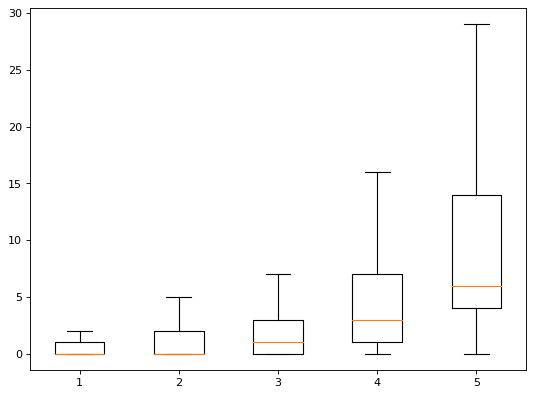

In [3]:
plt.figure(figsize=(8, 6), dpi=80)
plt.boxplot(scoreMatrix, showfliers=False)
plt.show()

Eigenvector : [4.05918906 0.62429605 0.21485351 0.06767572 0.03415668]
Eigenvalues : [[ 0.41216853  0.62363676  0.50669537 -0.42947531  0.00224683]
 [ 0.46345092  0.35859631 -0.21727026  0.71084154  0.3226761 ]
 [ 0.4793233  -0.01213915 -0.47372247 -0.12033056 -0.72884113]
 [ 0.46121148 -0.38244302 -0.29935082 -0.46285239  0.58067035]
 [ 0.41576855 -0.57972049  0.61808539  0.28555819 -0.16579394]]
Seperation percentages of PCs : [81.18100463198122, 12.48549389151639, 4.296923199161081, 1.3534680565789323, 0.6831102207623736]
Confidence number (C) = 7.0, Arthimetic average of all rating (m) = 4.195624815321344
Bayes average rating = [4.65901114 3.73477495 4.4943206  ... 4.46352818 4.33497153 4.14839069]


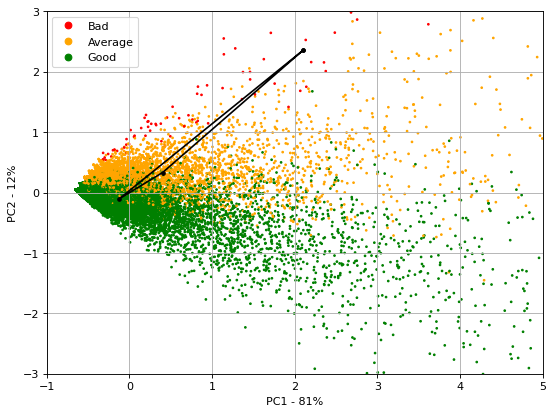

Classes count : {'Bad': 85, 'Average': 6534, 'Good': 22620}


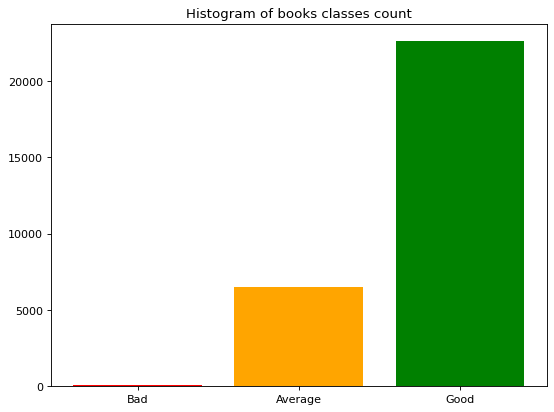

In [30]:
# Calculating PCA
normalizedScoreMatrix = (scoreMatrix - np.mean(scoreMatrix, axis = 0)) / np.std(scoreMatrix, axis = 0)
scoreMatrixCov = np.cov(normalizedScoreMatrix, rowvar = False) # rowvar allows us to transpose data!
eigenValues, eigenVectors = np.linalg.eig(scoreMatrixCov)
print(f"Eigenvector : {eigenValues}")
print(f"Eigenvalues : {eigenVectors}")

idx = np.argsort(eigenValues)[::-1]
evecs = eigenVectors[:,idx]
evals = eigenValues[idx]

# Variance of each Principal Component (PC)
evalsSum = sum(evals)
evalsVar = [ (eval/sum(evals)) * 100 for eval in evals ]
print(f"Seperation percentages of PCs : {evalsVar}")

#  PCA calculation and plotting
projectionMatrix = np.transpose(np.transpose(evecs)[:][:2])
scoreMatrixPCA = np.dot(normalizedScoreMatrix, projectionMatrix)

# Calculate better average metric to classify books
C = np.quantile(nbRating, 0.25)
m = np.mean(avgRatings)
print(f"Confidence number (C) = {C}, Arthimetic average of all rating (m) = {m}")
bayesAvgRatings = (nbRating * avgRatings + m * C) / (nbRating + C)
print(f"Bayes average rating = {bayesAvgRatings}")
classifierFunc = np.vectorize(lambda score: 0 if (score < 3) else 2 if (score > 4) else 1)
booksClasses = classifierFunc(bayesAvgRatings)

plt.figure(figsize=(8, 6), dpi=80)
plt.xlim(-1,5)
plt.ylim(-3,3)
plt.xlabel(f"PC1 - {math.floor(evalsVar[0])}%")
plt.ylabel(f"PC2 - {math.floor(evalsVar[1])}%")
plt.grid()
classes = ["Bad", 'Average', 'Good']
colorsList = ["red", "orange", "green"]
colors = ListedColormap(colorsList)
x, y = np.transpose(scoreMatrixPCA)
scatter = plt.scatter(x, y, c=booksClasses, cmap=colors, s=2)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

clusterCentersX = [np.mean(x[booksClasses == i]) for i in range(0,3)]
clusterCentersY = [np.mean(y[booksClasses == i]) for i in range(0,3)]
clusterCentersX.append(clusterCentersX[0])
clusterCentersY.append(clusterCentersY[0])
plt.plot(clusterCentersX, clusterCentersY, zorder=2, c="black")
plt.scatter(clusterCentersX, clusterCentersY, c="black", s=10)
plt.show()

plt.figure(figsize=(8, 6), dpi=80)
rateClasses, classFrequency = np.unique(booksClasses, return_counts=True)
print(f"Classes count : {dict(zip([classes[i] for i in rateClasses], classFrequency))}")
plt.bar([classes[i] for i in rateClasses], height=classFrequency, 
    color=[colorsList[i] for i in rateClasses], align="center") 
plt.title("Histogram of books classes count") 
plt.show()